# <올리스트 데이터 분석  - orders (주문데이터) 분석>

dataset : olist_orders_dataset.csv 
- orders 테이블 항목과 관련된 가설 검증
- 배송 예측 정확도 분석 (Gap(Delivered_Estimated)

## 라이브러리 로드

In [1]:
# 핑크색 warning 안내문 방지 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 데이터 분석에 사용할 라이브러리를 불러옵니다
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

## 폰트 로드

In [3]:
def get_font_family():
    """
    시스템 환경에 따른 기본 폰트명을 반환하는 함수
    """
    import platform
    system_name = platform.system()

    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        # Linux(Colab)
        !apt-get install fonts-nanum -qq  > /dev/null
        !fc-cache -fv

        import matplotlib as mpl
        mpl.font_manager._rebuild()
        findfont = mpl.font_manager.fontManager.findfont
        mpl.font_manager.findfont = findfont
        mpl.backends.backend_agg.findfont = findfont
        
        font_family = "NanumBarunGothic"
    return font_family

plt.rc("font", family=get_font_family())
plt.rc("axes", unicode_minus=False)

## 데이터로드

In [4]:
import glob

In [5]:
path = glob.glob('data/*.csv')
path

['data\\olist_customers_dataset.csv',
 'data\\olist_geolocation_dataset.csv',
 'data\\olist_orders_dataset.csv',
 'data\\olist_order_items_dataset.csv',
 'data\\olist_order_payments_dataset.csv',
 'data\\olist_order_reviews_dataset.csv',
 'data\\olist_products_dataset.csv',
 'data\\olist_sellers_dataset.csv',
 'data\\product_category_name_translation.csv']

In [6]:
# 주문 정보를 order라는 데이터프레임에 담을것 
order = pd.read_csv(path[2])

## 데이터 미리보기 및 요약

In [7]:
order.shape
# 99441개의 인덱스(행)과 8개의 컬럼(열)이 있다는 뜻

(99441, 8)

In [8]:
order.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

각 컬럼들 정보 

- order_id : 주문번호 
- customer_id : 고객번호 - 근데 요거 path[0] 보면 customer_id는 구매시마다 새로 생기는 id임. customer_unique_id가 진짜 고객 번호

                즉, order 테이블에서는 어떤 고객이 뭘 샀는지는 알 수 없지만 시계열데이터를 알아볼 수 있음 
- order_status : 주문상태
- order_purchase_timestamp : 주문일자 
- order_approved_at : 지불승인일자 (금융사 카드결제/ 통장입금확인되어 주문이 매출로 잡히는 시간 같음)
- order_delivered_carrier_date : 송장 나온날짜
- order_delivered_customer_date  : 배송완료일자(수령일자)
- order_estimated_delivery_date : 예상배송일자

# 검증하고자 하는 가설 :  배송 예측 정확도 분석 (Gap(Delivered_Estimated)

### 필요한 컬럼들만 추출 

In [9]:
order.sample(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
82021,e14f6f76cb42187a0831a2baf117f608,4b69f3639cc30d3f7def640b4a4ad87a,delivered,2018-08-07 15:23:50,2018-08-07 15:35:21,2018-08-09 11:52:00,2018-08-15 17:41:58,2018-08-30 00:00:00
42055,0eb0fc0795a4151d4ab39640998b0af4,e085f7dd45cff397f388c800b5f5c7a2,delivered,2018-01-06 16:48:29,2018-01-06 16:56:25,2018-01-10 18:29:00,2018-01-30 22:16:08,2018-02-16 00:00:00
24520,a72a85d8ae2274e218fcea46f815cfa7,151b2c4a56aab1fa8f3c822cc000b287,delivered,2018-07-05 10:50:33,2018-07-05 16:14:01,2018-07-06 10:57:00,2018-07-10 15:48:25,2018-07-20 00:00:00
90224,04ebaf1d65a804a49b4b1011467aaf47,0a71f8c6192e87a6cd6615bb9313d888,delivered,2017-11-24 09:37:11,2017-11-24 10:59:04,2017-11-29 21:32:24,2017-12-07 17:31:59,2017-12-14 00:00:00
86168,ee1d764213dcddf5a39ca6107a6a0ca8,1a89679a296852822ca3573d8ea0d041,delivered,2018-05-04 19:55:46,2018-05-05 19:50:51,2018-05-07 14:11:00,2018-05-18 21:12:10,2018-05-24 00:00:00


In [10]:
# 가져올 컬럼 - 구매일자, 배송시작일자, 배송완료일자, 예상배송일자
# 컬럼명 변경해서 새로운 데이터 프레임에 담자 

In [11]:
# 해당컬럼들을 data라는 변수에 담을거임 
date = order[['order_purchase_timestamp', 'order_delivered_carrier_date','order_delivered_customer_date', 'order_estimated_delivery_date']]
date.sample()

,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
81001,2017-07-09 12:25:07,2017-07-11 19:33:56,2017-07-21 01:29:36,2017-08-03 00:00:00


In [12]:
# 컬럼명 변경해주기 
date.rename(columns = {'order_purchase_timestamp':'주문일자',
                       'order_delivered_carrier_date' : '배송시작일자',
                      'order_delivered_customer_date' : '배송완료일자', 
                      'order_estimated_delivery_date': '예상배송일자'}, inplace= True)
date

,주문일자,배송시작일자,배송완료일자,예상배송일자
0,2017-10-02 10:56:33,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,2018-07-24 20:41:37,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,2018-08-08 08:38:49,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,2017-11-18 19:28:06,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,2018-02-13 21:18:39,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...
99436,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,2018-02-06 12:58:58,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,2017-08-27 14:46:43,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,2018-01-08 21:28:27,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00


In [13]:
# 컬럼들 문자열 슬라이싱으로 년-월-일 만 남기기 
date['주문일자'] = date['주문일자'].astype(str).str[:10]
date['배송시작일자'] = date['배송시작일자'].astype(str).str[:10]
date['배송완료일자'] = date['배송완료일자'].astype(str).str[:10]
date['예상배송일자'] = date['예상배송일자'].astype(str).str[:10]

In [14]:
date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   주문일자    99441 non-null  object
 1   배송시작일자  99441 non-null  object
 2   배송완료일자  99441 non-null  object
 3   예상배송일자  99441 non-null  object
dtypes: object(4)
memory usage: 3.0+ MB


In [15]:
# str로 변경된 데이터 타입 다시 datetime으로 바꿔주기 그래야 날짜 연산이 됨 
date['주문일자'] = pd.to_datetime(date['주문일자'])
date['배송시작일자'] = pd.to_datetime(date['배송시작일자'])
date['배송완료일자'] = pd.to_datetime(date['배송완료일자'])
date['예상배송일자'] = pd.to_datetime(date['예상배송일자'])
date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   주문일자    99441 non-null  datetime64[ns]
 1   배송시작일자  97658 non-null  datetime64[ns]
 2   배송완료일자  96476 non-null  datetime64[ns]
 3   예상배송일자  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](4)
memory usage: 3.0 MB


In [16]:
# 배송에 걸린 기간
date['배송기간'] = date['배송완료일자'] - date['주문일자']
date

,주문일자,배송시작일자,배송완료일자,예상배송일자,배송기간
0,2017-10-02,2017-10-04,2017-10-10,2017-10-18,8 days
1,2018-07-24,2018-07-26,2018-08-07,2018-08-13,14 days
2,2018-08-08,2018-08-08,2018-08-17,2018-09-04,9 days
3,2017-11-18,2017-11-22,2017-12-02,2017-12-15,14 days
4,2018-02-13,2018-02-14,2018-02-16,2018-02-26,3 days
...,...,...,...,...,...
99436,2017-03-09,2017-03-10,2017-03-17,2017-03-28,8 days
99437,2018-02-06,2018-02-07,2018-02-28,2018-03-02,22 days
99438,2017-08-27,2017-08-28,2017-09-21,2017-09-27,25 days
99439,2018-01-08,2018-01-12,2018-01-25,2018-02-15,17 days


In [17]:
# 시각화를 위해 datetime 형태인 배송기간을 float 형태로 변환해 배송기간1로 지정 
date['배송기간_숫자만'] = date['배송기간'].dt.days
date

,주문일자,배송시작일자,배송완료일자,예상배송일자,배송기간,배송기간_숫자만
0,2017-10-02,2017-10-04,2017-10-10,2017-10-18,8 days,8.0
1,2018-07-24,2018-07-26,2018-08-07,2018-08-13,14 days,14.0
2,2018-08-08,2018-08-08,2018-08-17,2018-09-04,9 days,9.0
3,2017-11-18,2017-11-22,2017-12-02,2017-12-15,14 days,14.0
4,2018-02-13,2018-02-14,2018-02-16,2018-02-26,3 days,3.0
...,...,...,...,...,...,...
99436,2017-03-09,2017-03-10,2017-03-17,2017-03-28,8 days,8.0
99437,2018-02-06,2018-02-07,2018-02-28,2018-03-02,22 days,22.0
99438,2017-08-27,2017-08-28,2017-09-21,2017-09-27,25 days,25.0
99439,2018-01-08,2018-01-12,2018-01-25,2018-02-15,17 days,17.0


# #분석 2. 구매에서 배송까지 평균 얼마나 걸리는지? 

In [18]:
# 주문일로부터 배송기간 별(그룹바이...) 빈도수 
date.groupby(by = '배송기간_숫자만')['배송기간'].count()

배송기간_숫자만
0.0         1
1.0       629
2.0      2874
3.0      3448
4.0      4497
         ... 
194.0       1
195.0       2
196.0       1
208.0       1
210.0       1
Name: 배송기간, Length: 144, dtype: int64

<AxesSubplot:xlabel='배송기간_숫자만'>

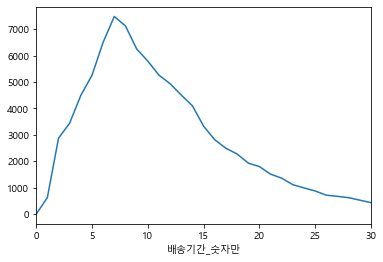

In [19]:
# 배송기간 별 빈도수 시각화 
plt.xlim(0,30)
date.groupby(by = '배송기간_숫자만').count()['배송기간'].plot()

In [20]:
date['배송기간_숫자만'].describe()

count    96476.000000
mean        12.497336
std          9.555460
min          0.000000
25%          7.000000
50%         10.000000
75%         16.000000
max        210.000000
Name: 배송기간_숫자만, dtype: float64

In [21]:
# 구매후 배송완료까지 평균 12일 정도. 중간값 10일 정말 빠르면 7일 ... 

# #분석 2. 배송예정일  / 배송완료일 사이의 GAP 

In [23]:
# 예상배송일과 실제배송일 INTERVAL 분석
date['기간차'] = date['예상배송일자'] - date['배송완료일자']
date

,주문일자,배송시작일자,배송완료일자,예상배송일자,배송기간,배송기간_숫자만,기간차
0,2017-10-02,2017-10-04,2017-10-10,2017-10-18,8 days,8.0,8 days
1,2018-07-24,2018-07-26,2018-08-07,2018-08-13,14 days,14.0,6 days
2,2018-08-08,2018-08-08,2018-08-17,2018-09-04,9 days,9.0,18 days
3,2017-11-18,2017-11-22,2017-12-02,2017-12-15,14 days,14.0,13 days
4,2018-02-13,2018-02-14,2018-02-16,2018-02-26,3 days,3.0,10 days
...,...,...,...,...,...,...,...
99436,2017-03-09,2017-03-10,2017-03-17,2017-03-28,8 days,8.0,11 days
99437,2018-02-06,2018-02-07,2018-02-28,2018-03-02,22 days,22.0,2 days
99438,2017-08-27,2017-08-28,2017-09-21,2017-09-27,25 days,25.0,6 days
99439,2018-01-08,2018-01-12,2018-01-25,2018-02-15,17 days,17.0,21 days


In [24]:
# 시각화를 위해 datetime 형태인 기간차을 float 형태로 변환해 기간차_숫자만으로 지정 
date['기간차_숫자만'] = date['기간차'].dt.days
date

,주문일자,배송시작일자,배송완료일자,예상배송일자,배송기간,배송기간_숫자만,기간차,기간차_숫자만
0,2017-10-02,2017-10-04,2017-10-10,2017-10-18,8 days,8.0,8 days,8.0
1,2018-07-24,2018-07-26,2018-08-07,2018-08-13,14 days,14.0,6 days,6.0
2,2018-08-08,2018-08-08,2018-08-17,2018-09-04,9 days,9.0,18 days,18.0
3,2017-11-18,2017-11-22,2017-12-02,2017-12-15,14 days,14.0,13 days,13.0
4,2018-02-13,2018-02-14,2018-02-16,2018-02-26,3 days,3.0,10 days,10.0
...,...,...,...,...,...,...,...,...
99436,2017-03-09,2017-03-10,2017-03-17,2017-03-28,8 days,8.0,11 days,11.0
99437,2018-02-06,2018-02-07,2018-02-28,2018-03-02,22 days,22.0,2 days,2.0
99438,2017-08-27,2017-08-28,2017-09-21,2017-09-27,25 days,25.0,6 days,6.0
99439,2018-01-08,2018-01-12,2018-01-25,2018-02-15,17 days,17.0,21 days,21.0


In [25]:
# 예측치 갭  별(그룹바이...) 빈도수 
date.groupby(by = '기간차_숫자만')['기간차'].count()

기간차_숫자만
-188.0    1
-181.0    1
-175.0    1
-167.0    1
-166.0    1
         ..
 109.0    1
 124.0    1
 135.0    1
 140.0    1
 147.0    1
Name: 기간차, Length: 198, dtype: int64

<AxesSubplot:xlabel='기간차_숫자만'>

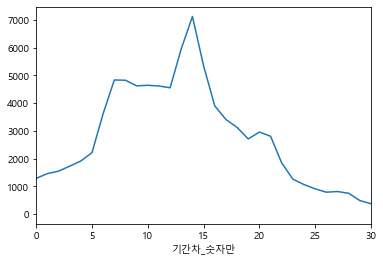

In [26]:
# 배송기간 별 빈도수 시각화 
plt.xlim(0,30)
date.groupby(by = '기간차_숫자만').count()['기간차'].plot()

<AxesSubplot:xlabel='기간차_숫자만'>

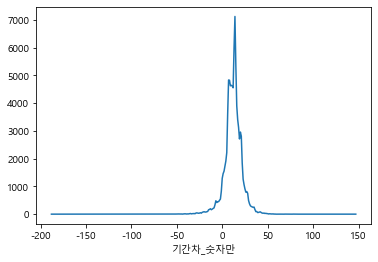

In [27]:
# 기간차 RANGE 미설정시 
date.groupby(by = '기간차_숫자만').count()['기간차'].plot()

In [28]:
date['기간차_숫자만'].describe()

count    96476.000000
mean        11.876881
std         10.183854
min       -188.000000
25%          7.000000
50%         12.000000
75%         17.000000
max        147.000000
Name: 기간차_숫자만, dtype: float64

# 평균적으로 실제배송일 / 배송예측일 간 갭은 11일 정도 , 
11~15일 정도의 갭... 
왜 그런걸까? 
브라질은 항공운송이 발달하고 철도랑 이런게 발달이 안되어있음. 항공운송량이 많아서? 그런거 같음 